In [1]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView
from scipy.stats import norm

In [3]:
# Read the fits file and save header
HI_cube = SpectralCube.read("HCG31.fits")
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv)/1e3) # to arcsec and GHz
print(delta_arcsec)

(265, 500, 500)
(1.500000000000012, 1.500000000000012, 5.513796271639699)


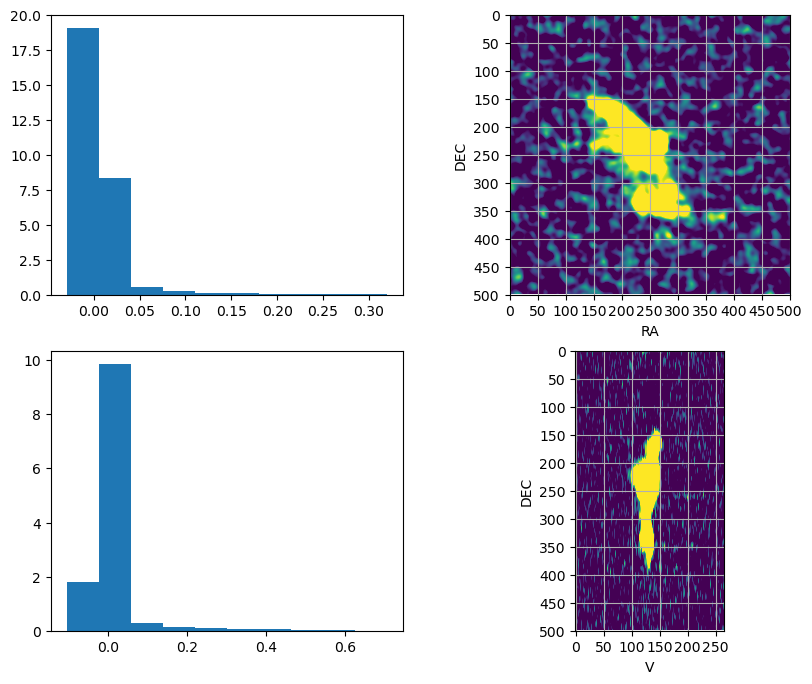

In [4]:
c3.preview2d(HI_cube.unmasked_data[:].to_value(), vmin1=0.00, vmax1=0.03, vmin2=0.01, vmax2=0.07, norm='asinh')

In [5]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [6]:
#HCG31
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [50, nx-51]
limy = [90, ny-81]
limz = [100, nz-71]

In [7]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('km/s').to_value()

In [8]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to_value()
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = c3.transpose(HI_cube, (dra,ddec,dv))

In [9]:
# calculate rms of data from negative values in the cube
_, rms = norm.fit(np.hstack([HI_cube[HI_cube<0].flatten(),-HI_cube[HI_cube<0].flatten()]))
print(rms)

0.00026820766


In [10]:
# Divide the cube by the RMS (optional)
HI_cube = HI_cube/rms

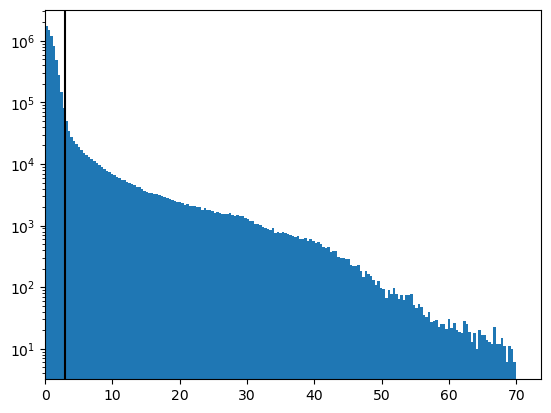

In [11]:
plt.hist(HI_cube.flatten(), bins=200);
plt.yscale('log')
plt.xlim(0,)
plt.axvline(3, color='k');

In [12]:
# isolevels in sigma
isolevels = np.array([3, 3.5, 4, 4.5, 5, 6, 7, 8 ,9, 10, 15, 20, 30, 50]) #hcg31

In [13]:
c = '0 0 1'
# HCG31 all from LVM et al. (2005)
gals = {'HCG31a':{'v':4090,'col':c},
       'HCG31b':{'v':4122,'col':c},
       'HCG31c':{'v':3984,'col':c},
        'HCG31g':{'v':4005,'col':c},
        'HCG31q':{'v':4090,'col':c}
       }

In [14]:
for (k,gal) in enumerate(gals.keys()):

    # Go from RA/Dec -> rescaled pixel space !
    coords = SkyCoord.from_name(gal)
    #coords = SkyCoord(gals[gal]['ra'], gals[gal]['dec'])
    #pixcrd = coords.to_pixel(w,1)
    
    coords.ra.deg = (coords.ra.deg-ramean.to_value())*np.cos(np.radians(declim[0]))*3600
    coords.dec.deg = (coords.dec.deg-decmean.to_value())*3600.

    gals[gal]['coord'] = np.array([coords.ra.deg, coords.dec.deg, gals[gal]['v']-vmean])

print(gals)

{'HCG31a': {'v': 4090, 'col': '0 0 1', 'coord': array([ 20.12338964, -16.78803281, 189.90453219])}, 'HCG31b': {'v': 4122, 'col': '0 0 1', 'coord': array([-20.9424172 , -30.19536881, 221.90453219])}, 'HCG31c': {'v': 3984, 'col': '0 0 1', 'coord': array([ 13.18539586, -11.25857681,  83.90453219])}, 'HCG31g': {'v': 4005, 'col': '0 0 1', 'coord': array([ 106.35102296, -122.09444081,  104.90453219])}, 'HCG31q': {'v': 4090, 'col': '0 0 1', 'coord': array([ 20.19019501, 116.22462319, 189.90453219])}}


In [15]:
coords = np.array([ralim, declim, vlim])
coords

array([[ 7.53205926e+01,  7.54873253e+01],
       [-4.32332630e+00, -4.18624294e+00],
       [ 3.64094704e+06,  4.15924389e+06]])

In [16]:
color = c3.create_colormap('magma', isolevels)

In [17]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers + {len(gals)} galaxies', 
        'description':'HI data cube of %s'%cubehead['OBJECT']
       }

In [18]:
# get an optical image from astroquery in the format needed for the x3d file (optional)
survey = ['DSS2 Blue']
verts = (coords[0,0], coords[0,1], coords[1,0], coords[1,1])
imcol, img_shape, img = c3.get_imcol(position='HCG31', survey=survey, verts=verts,
                                     unit='deg', pixels='4000',
                         coordinates='J2000',grid=True, gridlabels=True)

In [19]:
x3dname = 'HCG31.x3d'

In [20]:
file = c3.write_x3d(f'./{x3dname}', delta_arcsec, header=cubehead,
                    coords=coords, units=['mJy/beam', 'arcsec', 'arcsec', 'km/s'],
                     meta=meta, picking=False)

[[-299.26497834    0.          299.26497834]
 [-246.75005673    0.          246.75005673]
 [-259.14842477    0.          259.14842477]]


In [21]:
file.make_layers([HI_cube], [isolevels], [color], step_size=1, add_normals=False)
file.make_outline()
file.make_galaxies(gals=gals)
file.make_image2d(imcol=imcol, img_shape=img_shape)
file.make_ticklines()
file.make_animation()
file.make_labels(gals=gals, axlab='both') 
# html.func_scalev(axes) should be same as axlab, not func_axes() though.
split = file.iso_split
diffcoords = file.diff_coords
realcoords = file.real_coords
file.close()

In [22]:
tabtitle = 'HCG31'
pagetitle = 'HCG31 interactive HI datacube with X3D'
# add in desc for 2d image: <br>\n\t Background image: {survey}
desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}. RestFreq = {cubehead['RESTFREQ']/1e6:.4f} MHz.<br>\n\t Center: (RA,Dec,V)=({np.round(ramean,5)}, {np.round(decmean,5)}, {np.round(vmean,3)} km/s)"

In [23]:
html = c3.write_html(f'./{x3dname.split(".")[0]}.html', split=split, l_isolevels=[isolevels], units=['sigma', 'arcsec', 'arcsec', 'km/s'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=None)

In [24]:
html.func_layers([isolevels])
html.func_galaxies(gals)
html.func_gallab()
html.func_grids()
html.func_axes('both')
#html.func_pick() #for coordinate picking
html.func_animation()
html.start_x3d()
html.viewpoints(diffcoords[:,2])
html.close_x3d(x3dname)
html.buttons([isolevels], [color], colormaps=plt.colormaps(), hide2d=True, scalev=True, move2d=True, background=True)
html.func_tubes() #always after buttons
#func_move2dimage, func_colormaps and func_scalev must always go after buttons
#html.func_setCenterOfRotation(centers)
html.func_background()
html.func_galsize(gals)
html.func_image2d()
html.func_colormaps([isolevels])
html.func_scalev(gals=gals, axes='both', coords=diffcoords, move2d=True)
html.func_move2dimage(diffcoords[2,2], realcoords[2,2])
html.close_html()